In [3]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline

import dataloader
import util
import autoencoderdual
import esmda

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#load lsf architecture
LSDA = autoencoderdual.Autoencoder(x_train, y_reg_train, variational=False)
LSDA.train_autoencoder_dual_LSF(epoch=300, load=True)

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
enc (Conv2D)                    (None, 28, 28, 4)    40          input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 28, 28, 4)    0           enc[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 14, 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               12900     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 80)                8080      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 80)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 60)                4860      
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 60)                0         
__________

In [4]:
#get variables for LSDA
zm_test = LSDA.m2zm.predict(x_test)
zd_test = LSDA.d2zd.predict(y_reg_test)

In [5]:
#lsda workflow 
ref_case = 3
N_a = 4
alpha = [80, 30, 4, 1.5]

#data: in practice, remove/hide the ref_case from the ensemble
d_obs = y_reg_test[ref_case:ref_case+1, :].T

#call esmda method
esmda_method = esmda.ESMDA(ref_case, d_obs, LSDA, zm_test, zd_test)
Ensemble, Ensemble_d = esmda_method.assimilate(N_a, alpha)

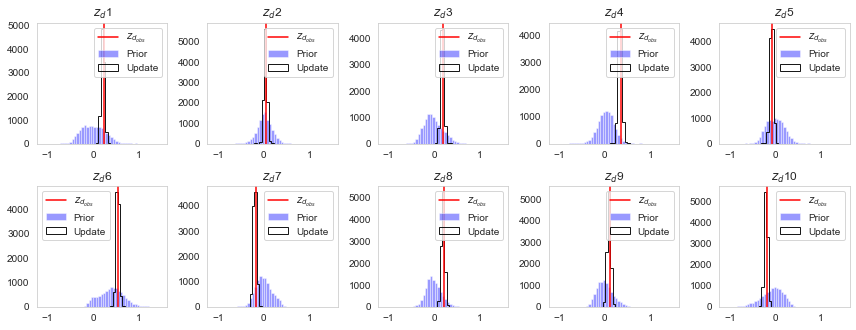

In [15]:
#plot for all latent variables
binmax = np.max(Ensemble_d[0])
binmin = np.min(Ensemble_d[0])
bb2 = np.linspace(binmin, binmax, 50)

f = plt.figure(figsize=(12, 9))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(Ensemble_d[0][i, :].flatten(), color='blue', alpha=0.4, bins=bb2, density=False, label="Prior")
    plt.hist(Ensemble_d[3][i, :].flatten(), color='blue', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=False, label="Update")
    plt.axvline(x=zd_test[ref_case:ref_case+1, i], c='r', label="$z_{d_{obs}}$")
    plt.grid(False)
    plt.title('$z_{d}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zds_demo.png')

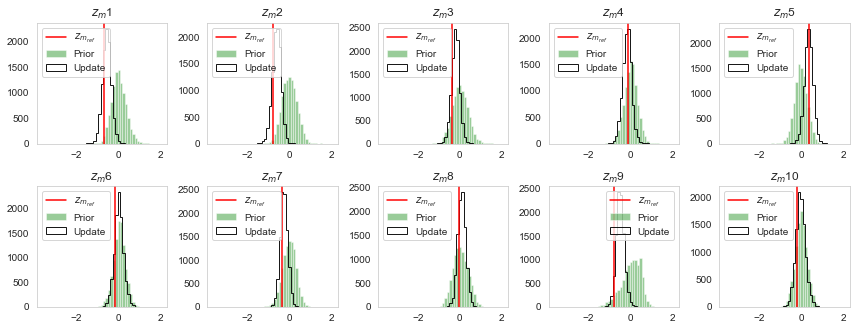

In [7]:
#plot for all latent variables
binmax = np.max(Ensemble[0])
binmin = np.min(Ensemble[0])
bb2 = np.linspace(binmin, binmax, 50)

f = plt.figure(figsize=(12, 9))
for i in range(0, 10):
    plt.subplot(4, 5, i+1)
    plt.hist(Ensemble[0][i, :].flatten(), color='green', alpha=0.4, bins=bb2, density=False, label="Prior")
    plt.hist(Ensemble[3][i, :].flatten(), color='green', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=False, label="Update")
    plt.axvline(x=zm_test[ref_case:ref_case+1, i], c='r', label="$z_{m_{ref}}$")
    plt.grid(False)
    plt.title('$z_{m}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zms_demo.png')

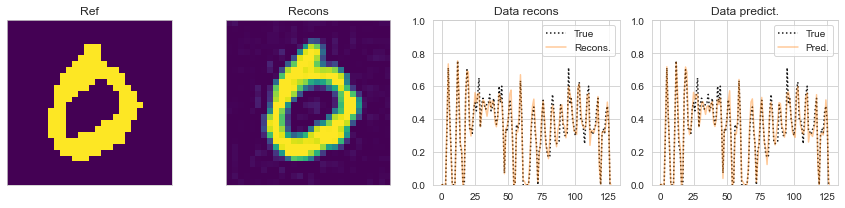

In [8]:
m_ref_hat = np.squeeze(LSDA.zm2m.predict(zm_test[ref_case:ref_case+1, :]))
y_reg_test_hat = LSDA.d2d.predict(y_reg_test)
y_reg_test_pred = LSDA.m2d.predict(x_test)

#model (i.e. reference case)
f = plt.figure(figsize=(12,3))
plt.subplot(1, 4, 1)
plt.imshow(x_test[ref_case], cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.title("Ref")

#model reconstruction (i.e. reference case)
plt.subplot(1, 4, 2)
plt.imshow(m_ref_hat, cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.title("Recons")

#data and data reconstruction
ax = f.add_subplot(1, 4, 3)
plt.plot(y_reg_test[ref_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_hat[ref_case, :], c=cs[y_test[ref_case]], label='Recons.', alpha=0.4)
plt.ylim([0, 1])
plt.title("Data recons")
plt.legend()

#data and data regression (i.e. forecast)
ax = f.add_subplot(1, 4, 4)
plt.plot(y_reg_test[ref_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_pred[1][ref_case, :], c=cs[y_test[ref_case]], label='Pred.', alpha=0.4)
plt.ylim([0, 1])
plt.title("Data predict.")
plt.legend()

plt.tight_layout()
f.savefig('readme/test_sigs_ref_regs_demo.png')

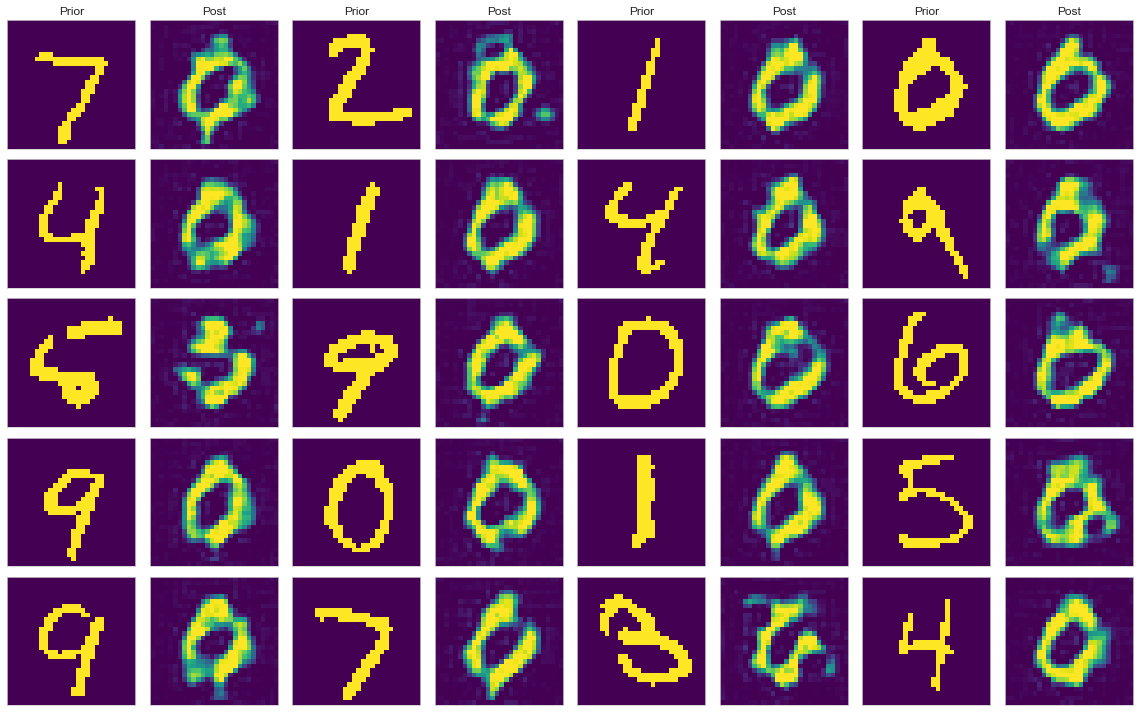

In [9]:
posteriors = LSDA.zm2m.predict(Ensemble[3].T)
    
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
    
f = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(x_test[i]), cmap="viridis", vmin=0, vmax=1) 
    if i < 4:
        plt.title("Prior")
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(posteriors[i]), cmap="viridis", vmin=0, vmax=1)
    if i < 4:
        plt.title("Post")
    
plt.tight_layout()
plt.show()

f.savefig('readme/test_prior_posts_demo.png')

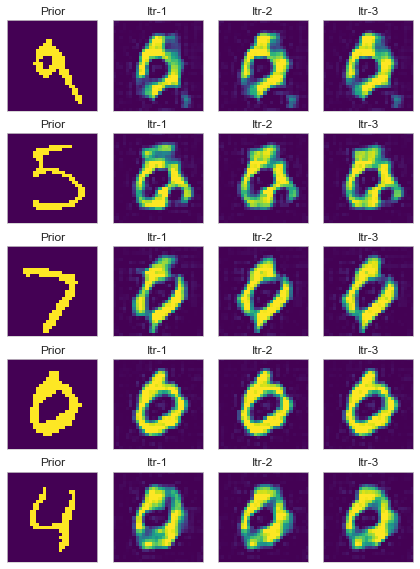

In [10]:
#display figures with iterations

img_itr1 = LSDA.zm2m.predict(Ensemble[1].T)
img_itr2 = LSDA.zm2m.predict(Ensemble[2].T)
img_itr3 = LSDA.zm2m.predict(Ensemble[3].T)

f = plt.figure(figsize=(6, 8))
for count, i in enumerate([7, 15, 17, 3, 4]):

    plt.subplot(5, 4, (4*(count))+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(x_test[i]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Prior")
    
    plt.subplot(5, 4, (4*(count))+2)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr1[i]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-1")
    
    plt.subplot(5, 4, (4*(count))+3)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr2[i]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-2")
    
    plt.subplot(5, 4, (4*(count))+4)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(img_itr3[i]), cmap="viridis", vmin=0, vmax=1) 
    plt.title("Itr-3")
    
plt.tight_layout()
f.savefig('readme/test_prior_posts_itrs_demo.png')

In [11]:
#mean and variance of prior and posterior

def plotmvar(data1, data2, name=[]):
    f = plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(data1), cmap="viridis", vmin=0, vmax=1, aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\mu$")

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(data2), cmap="viridis", vmin=0, vmax=0.25)
    plt.xticks([]), plt.yticks([])
    plt.title(name+"_$\sigma$")
    plt.tight_layout()
    f.savefig("readme/test_mean_var_"+name+"_demo.png")

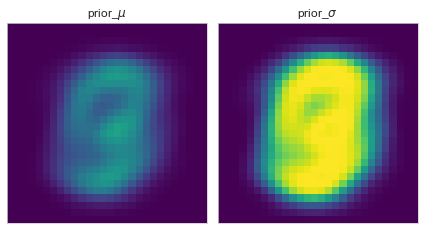

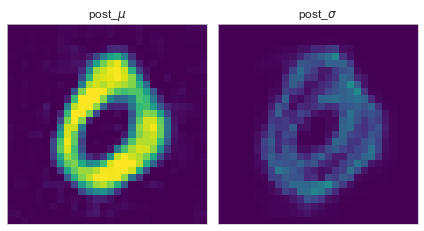

In [12]:
plotmvar(np.mean(x_test, axis=0), np.var(x_test, axis=0), name="prior")
plotmvar(np.mean(posteriors, axis=0), np.var(posteriors, axis=0), name="post")

In [13]:
#take cut off (0 and 1, cutoff at 0.5 for discrettization)
posteriors = np.where(posteriors<0.5, 0, 1)

#run forward simulation on the posteriors
G = np.load('G.npy')
y_dim = G.shape[-1]
D_posteriors = np.zeros([posteriors.shape[0], y_dim])
for i in range(D_posteriors.shape[0]):
    D_posteriors[i:i+1, :] = np.reshape((posteriors[i:i+1, :, :, 0]), [1, posteriors.shape[1]*posteriors.shape[2]])@G
    
#normalize using the same normalization factor for the training dataset
D_posteriors = D_posteriors/(dataset.maxs)

#data from posteriors (using proxy)
D_posteriors_proxy =  LSDA.zd2d.predict(Ensemble_d[-1].T)

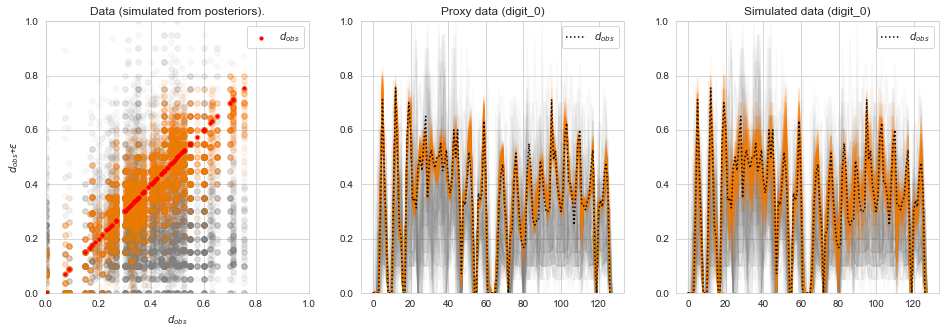

In [14]:
#view posteriors simulated data
f = plt.figure(figsize=(16, 5))
ax = f.add_subplot(1, 3, 1)
plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[ref_case,:].flatten(), s=10, color='red', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), y_reg_test[i,:].flatten(), s=30, color='gray', alpha=0.05)
for i in range(100):
    plt.scatter(y_reg_test[ref_case,:].flatten(), D_posteriors[i,:].flatten(), s=30, color=cs[y_test[ref_case]], alpha=0.05)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$d_{obs}$")
plt.ylabel("$d_{obs}$"+"+$\epsilon$")
plt.legend()
plt.title('Data (simulated from posteriors).')

ax = f.add_subplot(1, 3, 2)
timesteps = np.linspace(0, 127, 128)
plt.plot(timesteps, y_reg_test[ref_case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(100):
    plt.plot(timesteps, D_posteriors_proxy[i,:], color=cs[y_test[ref_case]], alpha=0.05)
plt.ylim([0, 1])
plt.title('Proxy data (digit_'+str(y_test[ref_case])+')')
plt.legend()

ax = f.add_subplot(1, 3, 3)
timesteps = np.linspace(0, 127, 128)
plt.plot(timesteps, y_reg_test[ref_case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(100):
    plt.plot(timesteps, D_posteriors[i,:], color=cs[y_test[ref_case]], alpha=0.05)
plt.ylim([0, 1])
plt.title('Simulated data (digit_'+str(y_test[ref_case])+')')
plt.legend()

f.savefig('readme/test_d_post_demo.png')